# Micromagnetic standard problem 4

**Authors**: Marijan Beg, Ryan A. Pepper, and Hans Fangohr

**Date**: 12 December 2016

## Problem specification

The sample is a thin film cuboid with dimensions:

- length $l_{x} = 500 \,\text{nm}$,
- width $l_{y} = 125 \,\text{nm}$, and
- thickness $l_{z} = 3 \,\text{nm}$.

The material parameters (similar to permalloy) are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Magnetisation dynamics are governed by the Landau-Lifshitz-Gilbert equation

$$\frac{d\mathbf{m}}{dt} = \underbrace{-\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff})}_\text{precession} + \underbrace{\alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)}_\text{damping}$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and Gilbert damping $\alpha=0.02$.

In the standard problem 4, the system is first relaxed at zero external magnetic field and then, starting from the obtained equlibrium configuration, the magnetisation dynamics are simulated for two external magnetic fields $\mathbf{B}_{1} = (-24.6, 4.3, 0.0) \,\text{mT}$ and $\mathbf{B}_{2} = (-35.5, -6.3, 0.0) \,\text{mT}$.

More detailed specification of Standard problem 4 can be found in Ref. 1.

## Simulation

In the first step, we import the required `discretisedfield` and `oommfc` modules.

In [1]:
import discretisedfield as df
import oommfc as oc

Now, we can set all required geometry and material parameters.

In [2]:
# Geometry
lx = 500e-9  # x dimension of the sample(m)
ly = 125e-9  # y dimension of the sample (m)
lz = 3e-9  # sample thickness (m)

# Material (permalloy) parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)

# Dynamics (LLG equation) parameters
gamma = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.02  # Gilbert damping

## First stage

In the first stage, we need to relax the system at zero external magnetic field.

We choose `stdprob4` to be the name of the system. This name will be used to name all output files created by OOMMF.

In [3]:
system = oc.System(name='stdprob4')

In order to completely define the micromagnetic system, we need to provide:

1. hamiltonian $\mathcal{H}$
2. dynamics $\text{d}\mathbf{m}/\text{d}t$
3. magnetisation $\mathbf{m}$

The mesh is created by providing two points `p1` and `p2` between which the mesh domain spans and the size of a discretisation cell. We choose the discretisation to be $(5, 5, 3) \,\text{nm}$.

In [4]:
cell = (5e-9, 5e-9, 3e-9)  # mesh discretisation (m)

mesh = oc.Mesh(p1=(0, 0, 0), p2=(lx, ly, lz), cell=cell)  # Create a mesh object.

We can visualise the mesh domain and a discretisation cell:

In [5]:
%matplotlib inline
mesh

**Hamiltonian:** In the second step, we define the system's Hamiltonian. In this standard problem, the Hamiltonian contains only exchange and demagnetisation energy terms. Please note that in the first simulation stage, there is no applied external magnetic field. Therefore, we do not add Zeeman energy term to the Hamiltonian.

In [6]:
system.hamiltonian = oc.Exchange(A) + oc.Demag()

We can check what is the continuous model of system's Hamiltonian.

In [7]:
system.hamiltonian

Exchange(A=1.3e-11) + Demag()

**Dynamics:** Similarly, the system's dynamics is defined by providing precession and damping terms (LLG equation).

In [8]:
system.dynamics = oc.Precession(gamma) + oc.Damping(alpha)

system.dynamics  # check the dynamics equation

Precession(gamma=221100.0) + Damping(alpha=0.02)

**Magnetisation:** Finally, we have to provide the magnetisation configuration that is going to be relaxed subsequently. We choose the uniform configuration in $(1, 0.25, 0.1)$ direction, and as norm (magnitude) we set the magnetisation saturation $M_\text{s}$. In order to create the magnetisation configuration, we create a `Field` object from the `discretisedfield` module.

In [9]:
system.m = df.Field(mesh, value=(1, 0.25, 0.1), norm=Ms)

Now, the system is fully defined.

**Energy minimisation:** The system (its magnetisation) is evolved using a particular driver. In the first stage, we need to relax the system - minimise its energy. Therefore, we create `MinDriver` object and drive the system using its `drive` method.

In [10]:
md = oc.MinDriver()  # create energy minimisation driver
md.drive(system)  # minimise the system's energy

2017/3/19 11:47: Calling OOMMF (stdprob4/stdprob4.mif) ... [1.1s]


The system is now relaxed. We can now obtain some data characteristic to the magnetisation field.

In [12]:
print('The average magnetisation is {}.'.format(system.m.average))

print('The magnetisation at the mesh centre {} is {}.'.format(
        system.m.mesh.centre, system.m(system.m.mesh.centre)))

The average magnetisation is (773766.18071369268, 99856.830066552473, -0.00013837057462025236).
The magnetisation at the mesh centre (2.5e-07, 6.25e-08, 1.5e-09) is [  7.99979274e+05  -5.75858666e+03   8.35954908e-04].


We can also plot the magnetisation along the diagonal:

$$\mathbf{r} = \mathbf{l}_{0} + d\mathbf{l},$$

with $\mathbf{l} = (500, 125, 3)$ and $\mathbf{l}_{0} = (0, 0, 0)$.

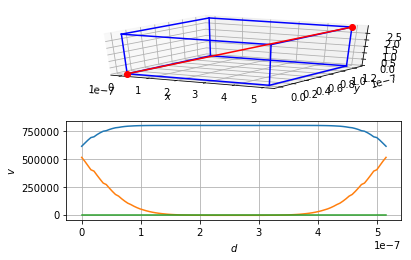

In [14]:
fig = system.m.plot_line_intersection((0, 0, 0), (lx, ly, lz))
fig

## Second stage: field $\mathbf{B}_{1}$

In the second stage, we need to apply an external magnetic field $\mathbf{B}_{1} = (-24.6, 4.3, 0.0) \,\text{mT}$ to the system. In other words, we have to add Zeeman energy term to the Hamiltonian.

In [15]:
# Add Zeeman energy term to the Hamiltonian
H1 = (-24.6e-3/oc.mu0, 4.3e-3/oc.mu0, 0.0)
system.hamiltonian += oc.Zeeman(H1)

If we now inspect the Hamiltonian, we see that an additional Zeeman term is added.

In [16]:
system.hamiltonian

Exchange(A=1.3e-11) + Demag() + Zeeman(H=(-19576.05800030313, 3421.8312764757497, 0.0))

Finally, we can run the simulation using `TimeDriver` this time. We run the magnetisation evolution for $t=1 \,\text{ns}$, during which we save the system's state $n=200$ times.

In [17]:
t = 1e-9  # simulation time (s)
n = 200  # number of data saving steps

td = oc.TimeDriver()  # create time driver
td.drive(system, t=t, n=n)  # drive the system

2017/3/19 11:49: Calling OOMMF (stdprob4/stdprob4.mif) ... [4.1s]


### Postprocessing

When we drove the system using the `TimeDriver`, we specified that we want to save the magnetisation configuration $n=200$ times. A detailed table of all computed parameters from the last simulation can be shown from the datatable (`system.dt`), which is a `pandas` dataframe [2].

For instance, if we want to show the last 10 rows in the table, we run:

In [17]:
system.dt

,E,Ecount,max_dm/dt,dE/dt,deltaE,Eex,max_spin_angle,stage_max_spin_angle,run_max_spin_angle,Ed,FixedZeeman:zeeman:Energy,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,4.118918e-18,31.0,274.704783,-6.372824e-11,-8.134832e-23,8.914546e-20,4.269744,4.269744,4.269744,5.454589e-19,3.484314e-18,5.0,5.0,0.0,0.966504,0.127263,-0.006302,1.411320e-12,5.000000e-12
1,4.118444e-18,44.0,377.559147,-1.335308e-10,-1.734404e-22,9.224944e-20,4.291308,4.291308,4.291308,5.540435e-19,3.472151e-18,8.0,2.0,1.0,0.964433,0.134275,-0.012478,1.433485e-12,1.000000e-11
2,4.117513e-18,69.0,497.003911,-2.454260e-10,-1.190174e-22,9.733529e-20,4.334073,4.334073,4.334073,5.684243e-19,3.451753e-18,12.0,3.0,2.0,0.960902,0.145695,-0.018497,4.981092e-13,1.500000e-11
3,4.115927e-18,88.0,617.386370,-3.948465e-10,-5.591260e-22,1.042704e-19,4.401764,4.401764,4.401764,5.889732e-19,3.422683e-18,16.0,3.0,3.0,0.955753,0.161309,-0.024329,1.510316e-12,2.000000e-11
4,4.113511e-18,107.0,734.281554,-5.761357e-10,-7.817999e-22,1.128594e-19,4.491564,4.491564,4.491564,6.162770e-19,3.384375e-18,20.0,3.0,4.0,0.948786,0.180843,-0.029939,1.424852e-12,2.500000e-11
5,4.110124e-18,126.0,840.117385,-7.825034e-10,-1.043791e-21,1.228462e-19,4.577817,4.577817,4.577817,6.510615e-19,3.336216e-18,24.0,3.0,5.0,0.939777,0.203969,-0.035288,1.386688e-12,3.000000e-11
6,4.105657e-18,145.0,937.759078,-1.006333e-09,-1.165829e-21,1.339276e-19,4.653411,4.653411,4.653411,6.941033e-19,3.277626e-18,28.0,3.0,6.0,0.928502,0.230302,-0.040340,1.190780e-12,3.500000e-11
7,4.100045e-18,164.0,1024.030415,-1.239770e-09,-1.252087e-21,1.457838e-19,4.716343,4.716343,4.716343,7.461345e-19,3.208126e-18,32.0,3.0,7.0,0.914756,0.259414,-0.045062,1.030096e-12,4.000000e-11
8,4.093256e-18,183.0,1100.006038,-1.475513e-09,-1.620335e-21,1.581152e-19,4.784602,4.784602,4.784602,8.077570e-19,3.127384e-18,36.0,3.0,8.0,0.898368,0.290843,-0.049432,1.118065e-12,4.500000e-11
9,4.085296e-18,202.0,1170.248816,-1.707644e-09,-1.922494e-21,1.706801e-19,4.879233,4.879233,4.879233,8.793811e-19,3.035234e-18,40.0,3.0,9.0,0.879211,0.324115,-0.053442,1.143381e-12,5.000000e-11


Finally, we want to plot the average magnetisation configuration `my` as a function of time `t`:

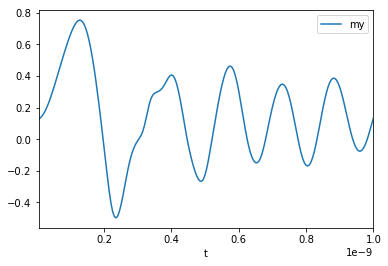

In [18]:
myplot = system.dt.plot("t", "my")

## References

[1] µMAG Site Directory: http://www.ctcms.nist.gov/~rdm/mumag.org.html
    
[2] Pandas: http://pandas.pydata.org/

In [1]:
import oommfdata as od

In [2]:
od.DataAnalysisODT('stdprob4')

Widget Javascript not detected.  It may not be installed or enabled properly.
